G5: Jakober, Winkler, Matzinger, Salzmann

# Convolutional Neural Network from CIFAR10 raw data using PyTorch

## Importing packages

In [1]:
# First, import pytorch, get its version and check available device.

import torch
print('Your torch version is {}'.format(torch.__version__))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Your torch version is 2.6.0+cu118


device(type='cuda')

In [2]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # for evaluating results
from tqdm.notebook import tqdm # for progress bars

from torch import nn
from torch.optim import Adam
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary

%matplotlib inline

## Downloading CIFAR dataset
Pytorch provides a set of pre-loaded datasets including CIFAR. We will convert our CIFAR images into tensors when loading them. There are lots of other transformations that you can do using torchvision.transforms like Reshaping, normalizing, etc. on your images but we won't need that since CIFAR is a very primitive dataset.


In [3]:
Transform = transforms.ToTensor() # let us convert cifar data to tensors
train_data = datasets.CIFAR10(
    root = 'data', # path to save cifar10 data
    train = True,                         
    transform = Transform, 
    download = True,            
)

test_data = datasets.CIFAR10(
    root = 'data', 
    train = False, 
    transform = Transform,
    download = True
)

## Printing train_data and test_data

In [4]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

## Visualization of CIFAR10 dataset


Size: torch.Size([3, 32, 32]) Label: 6


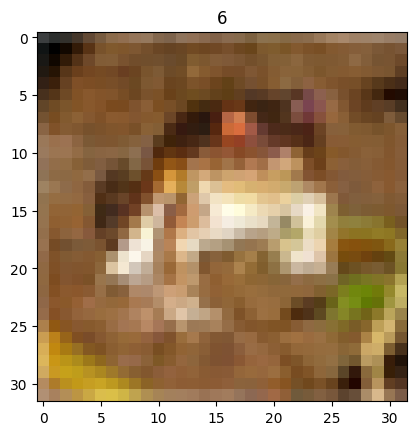

In [6]:
#Plot one train_data
img, target = train_data[0]
print('Size:', img.size(), 'Label:', target)
plt.imshow(img.permute(1, 2, 0)) # to fix the TypeError: Invalid shape (3, 32, 32) for image data
plt.title('%i' % target)
plt.show()

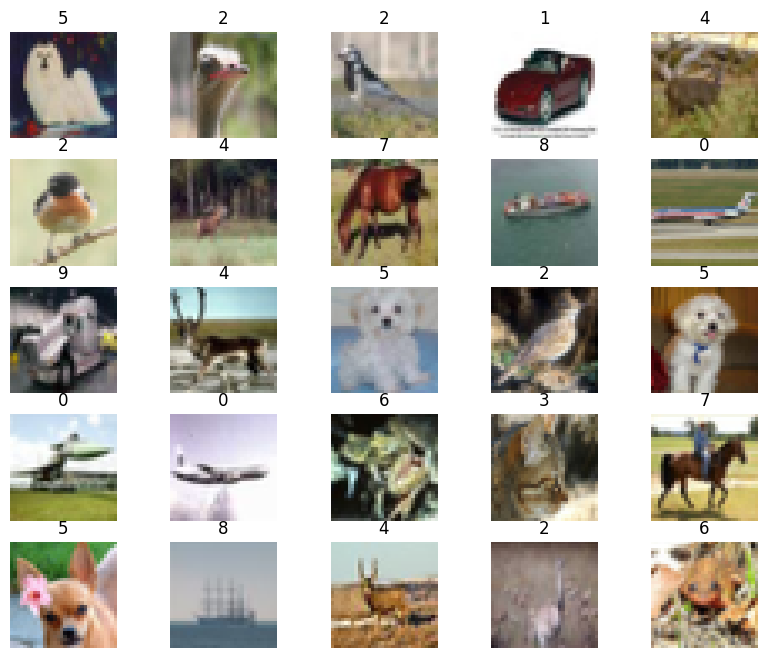

In [7]:
# Plot multiple train_data
def show_imgs(X):
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(X), size=(1,)).item()
        img, label = X[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.permute(1,2,0))
    plt.show()
    
show_imgs(train_data)

## Preparing data for training

In [8]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

# One-layer network
## Building the Network

In [9]:
input_dim = 32*32*3

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2d = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same")
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2) # 32x32x32 -> 16x16x32
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16*16*32, 10)

    def forward(self, x):
        x = self.conv2d(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
# use Adam as optimizer
lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

In [10]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
           Flatten-4                 [-1, 8192]               0
            Linear-5                   [-1, 10]          81,930
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.63
Params size (MB): 0.32
Estimated Total Size (MB): 0.95
----------------------------------------------------------------


## Training and evaluating the Model

Our model is now ready to be trained. Let's define functions to train() and validate() the model.

In [11]:
def train(epoch, model, data_loader, log_interval=200, l2_norm=False, verbose=True):
    model.train()
    total_train_loss = 0
    total_correct = 0

    # Loop over each batch from the training set
    for batch_idx, (X_train, y_train) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}", disable=not verbose)):
        # Copy data to GPU if needed
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        optimizer.zero_grad()
        output = model(X_train)
        
        # Calculate loss
        loss = criterion(output, y_train)

        if l2_norm:
            loss += 0.05 * sum(p.norm(2) for p in model.parameters())

        # Back-propagate
        loss.backward()
        
        # Update weights
        optimizer.step()

        total_train_loss += loss.item()

        _, y_pred = torch.max(output, dim=1)
        total_correct += torch.sum(y_pred == y_train).item()

        if batch_idx % log_interval == 0 and verbose:
            print(f'Train Epoch: {epoch} [{batch_idx * len(X_train)}/{len(data_loader.dataset)} ({100. * batch_idx / len(data_loader):.0f}%)]\tLoss: {loss.data.item():.6f}')
    
    accuracy_train = total_correct / len(data_loader.dataset)
    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [12]:
# torch.inference_mode() disables certain features that are not required
# for inference, such as autograd and other tracking.
# It's optional, but improves performance.
# Alternative: @torch.no_grad(), which only disables autograd. 
@torch.inference_mode()

def validate(model, data_loader, verbose=True):
    model.eval()

    val_loss = 0
    total_correct = 0
    total_preds = []
    total_targets = []

    for X_val, y_val in tqdm(data_loader, desc="Validation", disable=not verbose):
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        output = model(X_val)
        val_loss += criterion(output, y_val).item()
        
        _, y_pred = torch.max(output, dim=1)
        total_correct += torch.sum(y_pred == y_val).item()
        total_preds.append(y_pred.detach().cpu())
        total_targets.append(y_val.cpu())

    val_loss /= len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)

    if verbose:
        print(f"\nValidation set: Average loss: {val_loss:.4f}, Accuracy: {total_correct}/{len(data_loader.dataset)} ({100 * accuracy:.2f}%)\n")
    
    return {
        "loss": val_loss,
        "accuracy": accuracy,
        "predictions": torch.cat(total_preds),
        "targets": torch.cat(total_targets),
    }

Now we are ready to train our model using the train() function. An epoch means one pass through the whole training data. After each epoch, we evaluate the model using validate().

In [13]:
%%time

epochs = 5

# Keep track of stats to plot them
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    train_result = train(epoch, model, train_loader, l2_norm=False, verbose=True)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader, verbose=False)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.322979
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.492205


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.321723
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.328532


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.123310
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.210491


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.135923
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.239879


Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.926304
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.916696
CPU times: total: 43.9 s
Wall time: 49.4 s


## Loss and Accuracy evaluation during training

Let's now visualize how the training progressed.

Loss is a function of the difference of the network output and the target values. We are minimizing the loss function during training so it should decrease over time.
Accuracy is the classification accuracy for the test data.

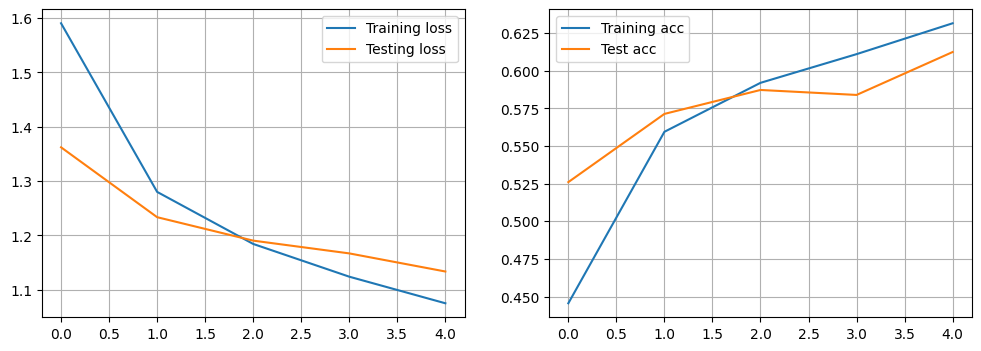

In [14]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

### Confusion matrix


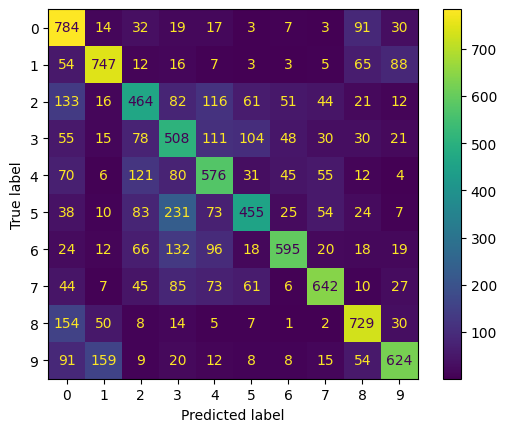

In [15]:
# val_result is from the validation of the last epoch above.
# But you could run it specifically with:
#
# val_result = validate(model, test_loader)

cm = confusion_matrix(val_result["targets"], val_result["predictions"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Comments
Looks already quite good, even with this simple architecture. Let's try some deeper CNNs

# Deeper CNN


In [23]:
input_dim = 32*32*3

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=1):
        super(ConvBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.layers(x)


class DeeperCNN(nn.Module):
    def __init__(self, num_layers = 1, kernel_size = 3, num_classes = 10):
        super().__init__()

        layers = [ConvBlock(in_channels=3, out_channels=32, kernel_size=kernel_size, padding="same")]

        current_channels = 32
        current_size = 32
        for _ in range(num_layers - 1):
            layers.append(nn.MaxPool2d(2))
            current_size //= 2 # With max pooling, the dimension halves
            layers.append(
                ConvBlock(in_channels=32, out_channels=32, kernel_size=kernel_size, padding="same")
            )

        layers.append(nn.MaxPool2d(2))
        current_size //= 2

        layers.append(nn.Flatten())

        linear_input_size = current_size * current_size * current_channels
        layers.append(nn.Linear(linear_input_size, num_classes))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

model = DeeperCNN().to(device)

criterion = nn.CrossEntropyLoss()
# use Adam as optimizer
lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

In [17]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         ConvBlock-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
           Flatten-6                 [-1, 8192]               0
            Linear-7                   [-1, 10]          81,930
Total params: 82,890
Trainable params: 82,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.13
Params size (MB): 0.32
Estimated Total Size (MB): 1.45
----------------------------------------------------------------


In [18]:
%%time

epochs = 30

# Keep track of stats to plot them
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(1, epochs + 1), desc="Epoch"):
    train_result = train(epoch, model, train_loader, l2_norm=True, verbose=False)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])

    val_result = validate(model, test_loader, verbose=False)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: total: 4min 6s
Wall time: 4min 22s


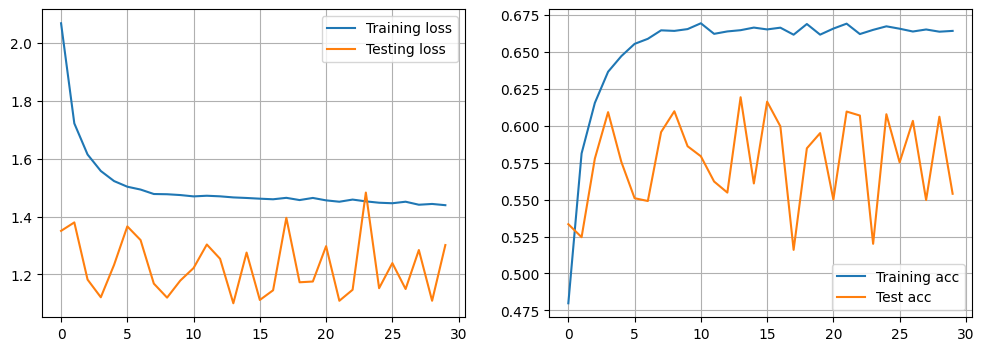

In [19]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

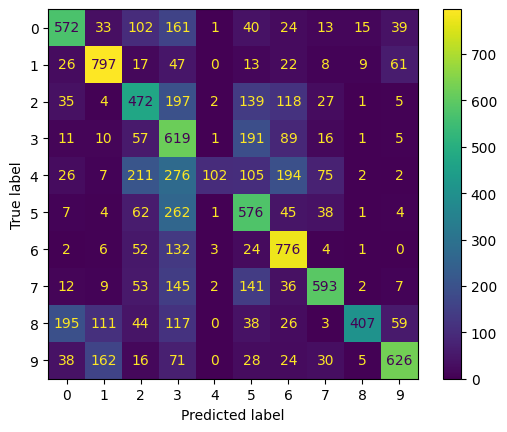

In [20]:
cm = confusion_matrix(val_result["targets"], val_result["predictions"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Comments:
Already rather good results and good curve on the training set, however the accuracy on the validation-set is really shaky and a bit lower that the training accuracy. Lets try to tackle that with other architectures.


Run 1/6 with 1 Layer and a kernel size of 5


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training Run 1:
	Train-Acc: 0.6604
	Val-Acc: 0.5711

Run 2/6 with 2 Layers and a kernel size of 5


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training Run 2:
	Train-Acc: 0.724
	Val-Acc: 0.6004

Run 3/6 with 4 Layers and a kernel size of 5


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training Run 3:
	Train-Acc: 0.78258
	Val-Acc: 0.6681

Run 4/6 with 1 Layer and a kernel size of 3


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training Run 4:
	Train-Acc: 0.6587
	Val-Acc: 0.6363

Run 5/6 with 2 Layers and a kernel size of 3


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training Run 5:
	Train-Acc: 0.72088
	Val-Acc: 0.5947

Run 6/6 with 4 Layers and a kernel size of 3


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training Run 6:
	Train-Acc: 0.7787
	Val-Acc: 0.6548


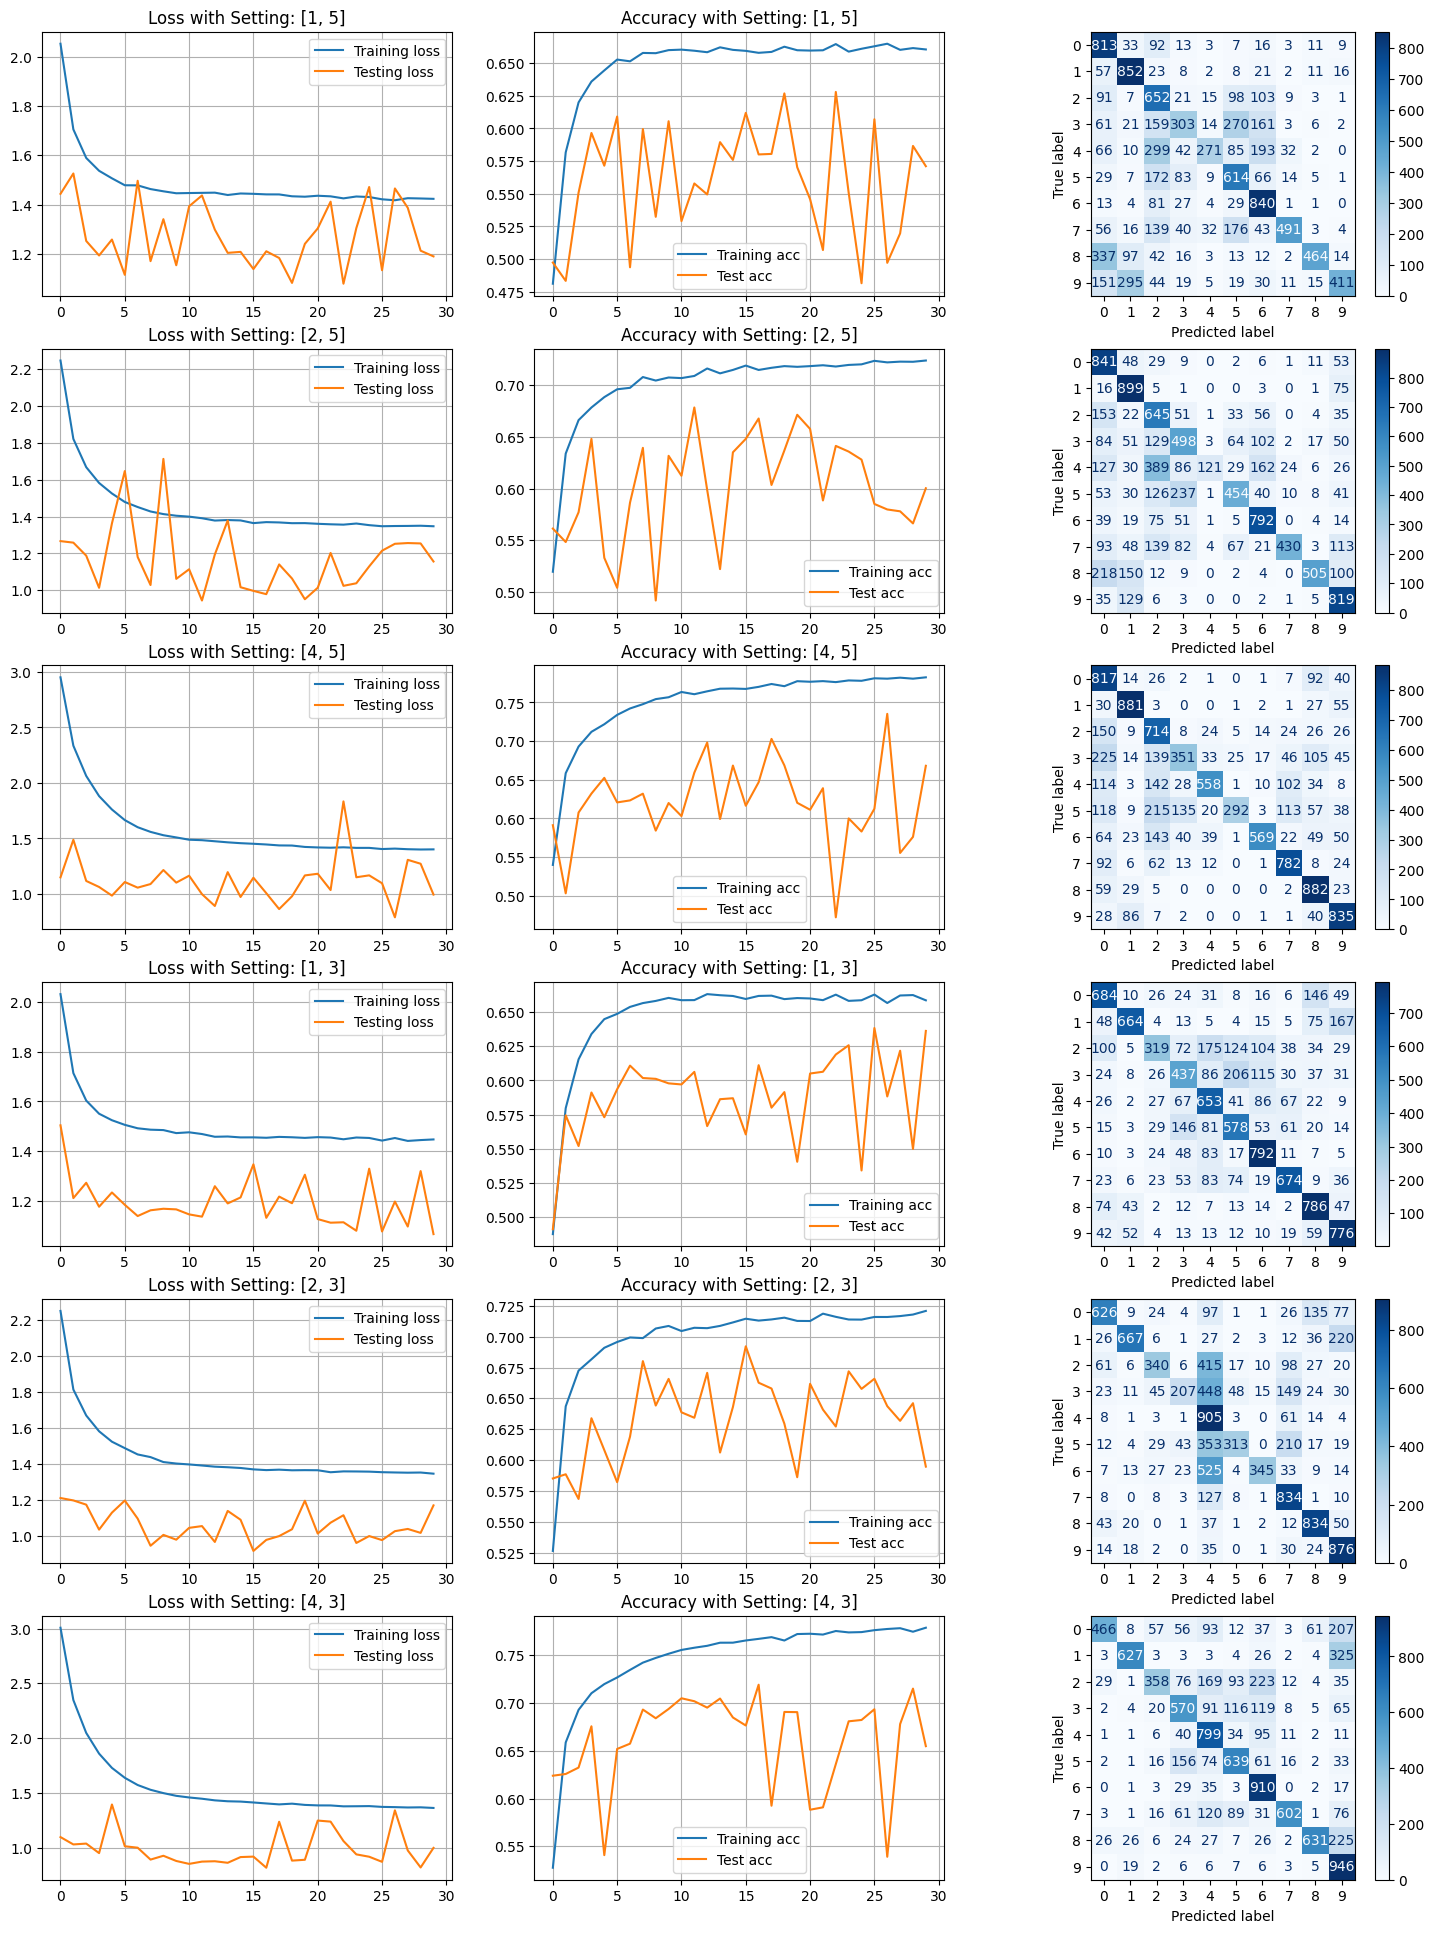

In [24]:
# Settings: Num Layers, kernel_size

settings = [
    [1, 5],
    [2, 5],
    [4, 5],
    [1, 3],
    [2, 3],
    [4, 3]
]

criterion = nn.CrossEntropyLoss()

fig, axes = plt.subplots(len(settings), 3, figsize=(18, 4 * len(settings)))

for i, setting in enumerate(settings):
    print(f"\nRun {i+1}/{len(settings)} with {setting[0]} {'Layers' if setting[0] > 1 else 'Layer'} and a kernel size of {setting[1]}")
    num_layers, kernel_size = setting
    model = DeeperCNN(num_layers, kernel_size).to(device)

    lr = 0.001
    optimizer = Adam(model.parameters(), lr=lr)

    # Keep track of stats to plot them
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in tqdm(range(1, epochs + 1), desc="Epoch"):
        train_result = train(epoch, model, train_loader, l2_norm=True, verbose=False)
        train_losses.append(train_result["loss"])
        train_accuracies.append(train_result["accuracy"])

        val_result = validate(model, test_loader, verbose=False)
        val_losses.append(val_result["loss"])
        val_accuracies.append(val_result["accuracy"])

    print(f"Training Run {i+1}:\n\tTrain-Acc: {train_accuracies[-1]}\n\tVal-Acc: {val_accuracies[-1]}")

    axes[i, 0].plot(train_losses, label='Training loss')
    axes[i, 0].plot(val_losses, label='Testing loss')
    axes[i, 0].set_title(f"Loss with Setting: {setting}")
    axes[i, 0].legend()
    axes[i, 0].grid()

    axes[i, 1].plot(train_accuracies, label='Training acc')
    axes[i, 1].plot(val_accuracies, label='Test acc')
    axes[i, 1].set_title(f"Accuracy with Setting: {setting}")
    axes[i, 1].legend()
    axes[i, 1].grid()

    cm = confusion_matrix(val_result["targets"], val_result["predictions"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i, 2], cmap="Blues")

plt.show()

Note: Conv-Block = Conv2D -> BatchNorm -> ReLU, so 3 Layers each

| Run Nr. | Architecture                                                                                                                                                                                                                                                                                       | Acc. Train |  Acc. Test |
|---------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------:|-----------:|
| 1       | Layer 1: CONV-Block D=32, w=h=5, S1, P="same",<br/>Layer 2: MaxPool size=2<br/>Layer 3: Linear Layer input_dim=8192, output_dim=10                                                                                                                                                                 |     66.04% |     57.11% |
| 2       | Layer 1: CONV-Block D=32, w=h=5, S1, P="same",<br/>Layer 2: MaxPool size=2<br/>Layer 3: CONV-Block D=16, w=h=5, S1, P="same",<br/>Layer 4: MaxPool size=2<br/>Layer 5: Linear Layer input_dim=2048, output_dim=10                                                                                  |     72.40% |     60.04% |
| **3**   | **Layer 1: CONV-Block D=32, w=h=5, S1, P="same",<br/>Layer 2: MaxPool size=2<br/>Layer 3: CONV-Block D=16, w=h=5, S1, P="same",<br/>Layer 4: MaxPool size=2<br/>Layer 5: CONV-Block D=8, w=h=5, S1, P="same",<br/>Layer 6: MaxPool size=2<br/>Layer 7: Linear Layer input_dim=512, output_dim=10** | **78.26%** | **66.81%** |
| 4       | Layer 1: CONV-Block D=32, w=h=3, S1, P="same",<br/>Layer 2: MaxPool size=2<br/>Layer 3: Linear Layer input_dim=8192, output_dim=10                                                                                                                                                                 |     65.87% |     63.63% |
| 5       | Layer 1: CONV-Block D=32, w=h=3, S1, P="same",<br/>Layer 2: MaxPool size=2<br/>Layer 3: CONV-Block D=16, w=h=5, S1, P="same",<br/>Layer 4: MaxPool size=2<br/>Layer 5: Linear Layer input_dim=2048, output_dim=10                                                                                  |     72.09% |     59.47% |
| 6       | Layer 1: CONV-Block D=32, w=h=3, S1, P="same",<br/>Layer 2: MaxPool size=2<br/>Layer 3: CONV-Block D=16, w=h=5, S1, P="same",<br/>Layer 4: MaxPool size=2<br/>Layer 5: CONV-Block D=8, w=h=5, S1, P="same",<br/>Layer 6: MaxPool size=2<br/>Layer 7: Linear Layer input_dim=512, output_dim=10     |     77.87% |     65.48% |

## Comments

The best Run was Run number 3. It had 3 Convolution-Blocks, each consisting of a Conv2D-Layer, BatchNorm and a ReLU. The Kernel-size in that run was 5.

